# Volume–Volatility: MA and AR Models
This notebook fits Moving Average MA(q) and Autoregressive AR(p) models to trading volume V_t,
using the pre-split files `train_data.csv` and `test_data.csv` produced in data preparation.


In [13]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt

In [14]:
def residual_diagnostics(resid, lags=24):
    """Basic diagnostics for ε_t: mean, std, Ljung–Box p-value at given lag."""
    r = pd.Series(resid).dropna()
    lb = acorr_ljungbox(r, lags=[lags], return_df=True)
    return {
        "eps_mean": float(r.mean()),
        "eps_std": float(r.std(ddof=1)),
        f"LjungBox_p(lag{lags})": float(lb["lb_pvalue"].iloc[-1]),
    }

def mae(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    return float(np.mean(np.abs(y - yhat)))

def mape(y, yhat):
    y, yhat = np.asarray(y), np.asarray(yhat)
    denom = np.where(y == 0, np.nan, y)
    return float(np.nanmean(np.abs((y - yhat) / denom)) * 100.0)


In [15]:
# Expect columns at least: date, volume_all (or your chosen target), vix, hist_vol, ...
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Choose target V_t (volume). If you prefer logs, switch to "log_volume".
target_col = "volume_all"
V_tr = train[target_col]
V_te = test[target_col]


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723


In [5]:
from statsmodels.tsa.stattools import adfuller

def adf_p(x):
    x = pd.Series(x).dropna()
    return adfuller(x, autolag="AIC")[1]

# Lastes likevel inn i Box 4 under – men vi tester på råkolonnen etterpå


ADF p-value (raw volume): 0.17170
ADF p-value (log volume): 0.14445


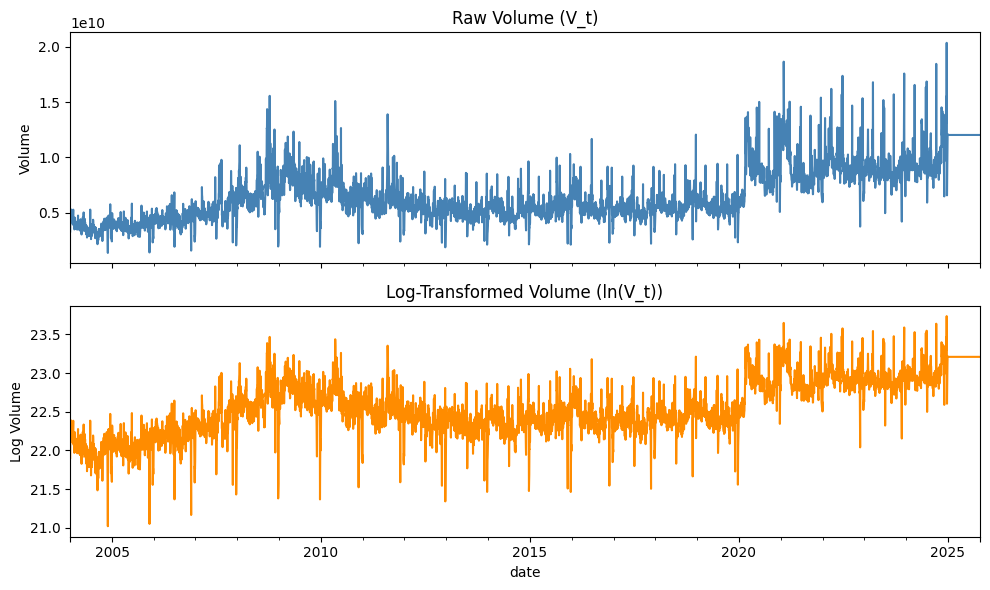

In [6]:
# --- Stationarity diagnostics before defining final series ---
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Read the merged dataset directly (before splitting)
df_full = pd.read_csv("merged_volume_volatility.csv", parse_dates=["date"]).set_index("date").sort_index()

# Create log of volume
df_full["log_volume"] = np.log(df_full["volume_all"])

# ADF test on both raw and log series
p_raw = adfuller(df_full["volume_all"].dropna(), autolag="AIC")[1]
p_log = adfuller(df_full["log_volume"].dropna(), autolag="AIC")[1]

print(f"ADF p-value (raw volume): {p_raw:.5f}")
print(f"ADF p-value (log volume): {p_log:.5f}")

# Plot comparison
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

df_full["volume_all"].plot(ax=ax[0], color="steelblue")
ax[0].set_title("Raw Volume (V_t)")
ax[0].set_ylabel("Volume")

df_full["log_volume"].plot(ax=ax[1], color="darkorange")
ax[1].set_title("Log-Transformed Volume (ln(V_t))")
ax[1].set_ylabel("Log Volume")

plt.tight_layout()
plt.show()


In [7]:
train = pd.read_csv("train_data.csv", parse_dates=["date"]).set_index("date").sort_index()
test  = pd.read_csv("test_data.csv",  parse_dates=["date"]).set_index("date").sort_index()

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  rows={len(train)}")
print(f"Test:  {test.index.min().date()}  → {test.index.max().date()}   rows={len(test)}")

# Bruk log av volum
train["log_volume"] = np.log(train["volume_all"])
test["log_volume"]  = np.log(test["volume_all"])

# Målserie
V_tr = train["log_volume"]
V_te = test["log_volume"]

# Rask stasjonaritetssjekk (valgfritt, info)
print("ADF p-value (train, log_volume):", adf_p(V_tr))


Train: 2004-01-01 → 2022-12-30  rows=4957
Test:  2023-01-02  → 2025-10-08   rows=723
ADF p-value (train, log_volume): 0.021968939716481256


## The Moving Average (MA) Model

In [ ]:
# --- Moving Average (MA) model consistent with the theoretical formula ---
# Formula: V_t = c + ε_t + Σ θ_j ε_{t-j}

q = 1  # order of the MA(q) model

# 1) Fit MA(q) on the log-transformed series including a constant (trend='c' == c in the formula)
ma_model = sm.tsa.SARIMAX(
    V_tr,                   # V_t in log-scale
    order=(0, 0, q),        # MA(q)
    trend='c',              # include constant term c
    enforce_stationarity=False,
    enforce_invertibility=True
)
ma_res = ma_model.fit(disp=False)

# Parameters:
# 'const' = c, 'ma.L1'...'ma.Lq' = θ1...θq
print(ma_res.summary().tables[1])

# 2) One- and multi-step forecasts in log-scale
n_fore = min(60, len(V_te))
ma_pred_log = ma_res.get_forecast(steps=n_fore).predicted_mean

# 3) Convert forecasts back to the original (volume) scale
ma_pred = np.exp(ma_pred_log)
V_te_lin = np.exp(V_te.iloc[:n_fore])

# 4) Simple evaluation metrics
print(f"MA(q={q})  MAE: {np.mean(np.abs(V_te_lin - ma_pred)):.3f}")



                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.4764      0.005   4138.545      0.000      22.466      22.487
ma.L1          0.6664      0.009     70.824      0.000       0.648       0.685
sigma2         0.0525      0.001     64.051      0.000       0.051       0.054
MA(q=1)  MAE: 3722278852.837


In [11]:
fc = ma_res.get_forecast(steps=len(V_te))
sf = fc.summary_frame()

# Bias-korrigert tilbakeføring fra logg til nivå
mu = sf["mean"]
sigma2 = sf["mean_se"]**2
pred_level = np.exp(mu + 0.5 * sigma2)

diag_ma = residual_diagnostics(ma_res.resid, lags=24)

print("Diagnostics MA(q):", diag_ma)
print(
    f"MA(q={ma_res.model_orders['ma']})  "
    f"MAE(level):  {mae(np.exp(V_te), pred_level):.3f}   "
    f"MAPE(level): {mape(np.exp(V_te), pred_level):.2f}%"
)


Diagnostics MA(q): {'eps_mean': 0.00429274669000098, 'eps_std': 0.3862509616198683, 'LjungBox_p(lag24)': 0.0}
MA(q=1)  MAE(level):  4120567633.782   MAPE(level): 38.82%


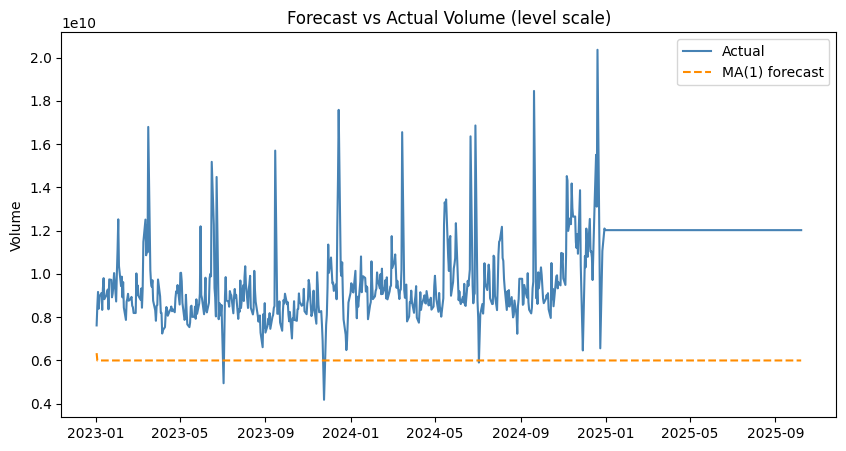

In [12]:
plt.figure(figsize=(10,5))
plt.plot(V_te.index, np.exp(V_te), label="Actual", color="steelblue")
plt.plot(V_te.index, pred_level, label=f"MA({q}) forecast", color="darkorange", linestyle="--")
plt.title("Forecast vs Actual Volume (level scale)")
plt.ylabel("Volume")
plt.legend()
plt.show()

## AutoRegressive (AR) Model

In [ ]:
# Equation in the paper:
# V_t = c + Σ_{i=1..p} φ_i V_{t-i} + ε_t

p = 1  # try small values like 1–4, or grid-search below

ar_model = sm.tsa.SARIMAX(
    V_tr,
    order=(p, 0, 0),
    trend = 'c',               # (p, d, q) with q=0, d=0 → AR(p)
    enforce_stationarity=False,
    enforce_invertibility=False,
)

ar_res = ar_model.fit(disp=False)
print(ar_res.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   9683.220      0.000       1.000       1.000
sigma2         0.0265      0.000    112.211      0.000       0.026       0.027


In [10]:
diag_ar = residual_diagnostics(ar_res.resid, lags=24)
ar_pred = ar_res.get_forecast(steps=len(V_te)).predicted_mean

print("Diagnostics AR(p):", diag_ar)
print(f"AR(p={ar_res.model_orders['ar']})  MAE:  {mae(V_te, ar_pred):.3f}   MAPE: {mape(V_te, ar_pred):.2f}%")


Diagnostics AR(p): {'eps_mean': 0.005006081020794408, 'eps_std': 0.35090076597160896, 'LjungBox_p(lag24)': 0.2962547320845154}
AR(p=1)  MAE:  0.552   MAPE: 2.39%


## Compare MA and AR

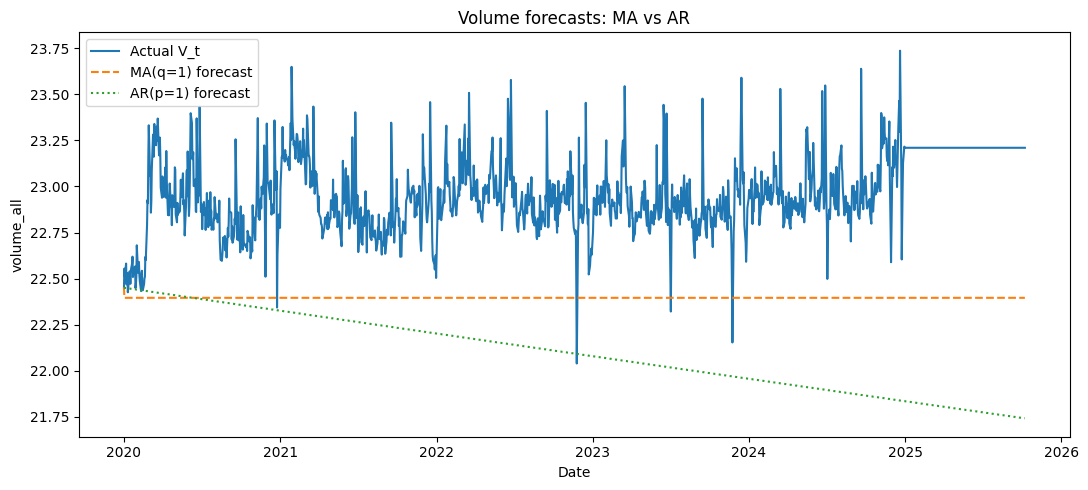

In [38]:
plt.figure(figsize=(11, 5))
plt.plot(V_te.index, V_te.values, label="Actual V_t")
plt.plot(V_te.index, ma_pred.values, label=f"MA(q={ma_res.model_orders['ma']}) forecast", linestyle="--")
plt.plot(V_te.index, ar_pred.values, label=f"AR(p={ar_res.model_orders['ar']}) forecast", linestyle=":")
plt.title("Volume forecasts: MA vs AR")
plt.xlabel("Date")
plt.ylabel(target_col)
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
def aic_grid_ma(y, q_max=4):
    rows = []
    for q in range(1, q_max + 1):
        try:
            r = sm.tsa.SARIMAX(y, order=(0, 0, q),
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit(disp=False)
            rows.append((q, r.aic))
        except Exception:
            rows.append((q, np.inf))
    return pd.DataFrame(rows, columns=["q", "AIC"]).sort_values("AIC")

def aic_grid_ar(y, p_max=4):
    rows = []
    for p in range(1, p_max + 1):
        try:
            r = sm.tsa.SARIMAX(y, order=(p, 0, 0),
                               enforce_stationarity=False,
                               enforce_invertibility=False).fit(disp=False)
            rows.append((p, r.aic))
        except Exception:
            rows.append((p, np.inf))
    return pd.DataFrame(rows, columns=["p", "AIC"]).sort_values("AIC")

display(aic_grid_ma(V_tr, q_max=4))
display(aic_grid_ar(V_tr, p_max=4))


,q,AIC
3,4,195340.905485
2,3,195489.038001
1,2,195805.384011
0,1,196554.459739


,p,AIC
3,4,183747.245853
2,3,183913.458397
1,2,184054.115804
0,1,184483.925752


In [21]:
scores = pd.DataFrame({
    "MAE":   [mae(V_te, ma_pred), mae(V_te, ar_pred)],
    "MAPE":  [mape(V_te, ma_pred), mape(V_te, ar_pred)],
}, index=[f"MA(q={ma_res.model_orders['ma']})", f"AR(p={ar_res.model_orders['ar']})"])

display(scores)


,MAE,MAPE
MA(q=1),9.563371e+09,99.950322
AR(p=1),9.301682e+09,96.553772
